## This notebook uses pickle file which is generated as part of the modelling step. This branch has corresponding call to create pickle file. Please run the modeling step of pipeline before running the analysis below.

# Importing required packages 

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import Markdown as md

import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


%matplotlib inline

# Loading dataframe used in modeling 

In [3]:
df = pickle.load(open( "../src/model_df_cambridge.pkl", "rb"))

In [4]:
df.head()

,segment_id,target,pre_week,pre_month,pre_quarter,avg_week,width,parking_tickets,lanes,hwy_type,...,oneway1,signal0,signal1,signal2,signal3,signal4,signal5,log_width,log_parking_tickets,intersection
0,0010,0,0,1,1,0.007576,0,1,2,1,...,1,1,0,0,0,0,0,0.000000,0.693147,0
1,00100,0,0,0,0,0.030303,21,3762,2,1,...,0,1,0,0,0,0,0,3.091042,8.232972,0
2,001001,0,0,0,1,0.007576,21,272,2,5,...,0,1,0,0,0,0,0,3.091042,5.609472,0
3,001009,0,0,0,0,0.007576,15,23,2,0,...,1,1,0,0,0,0,0,2.772589,3.178054,0
4,001014,0,0,0,0,0.007576,15,187,2,5,...,0,1,0,0,0,0,0,2.772589,5.236442,0


# Correlation matrix

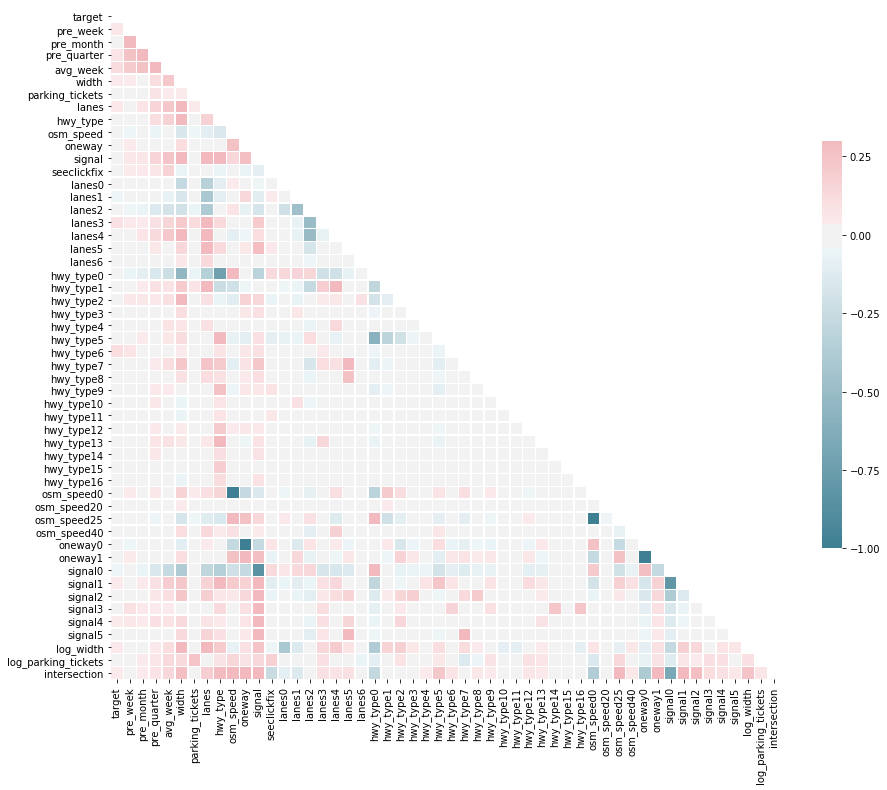

In [5]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation between average weekly crash in a segment with other variables (sorted in desc order)

In [6]:
print(pd.Series(corr["avg_week"]).sort_values())

signal0               -0.260301
hwy_type0             -0.230973
lanes2                -0.194410
lanes1                -0.079339
osm_speed25           -0.032956
osm_speed             -0.030833
oneway0               -0.023333
hwy_type16            -0.011799
lanes6                -0.011799
hwy_type8             -0.009158
hwy_type14            -0.004574
hwy_type15             0.000420
hwy_type12             0.003549
osm_speed20            0.008860
osm_speed40            0.008923
hwy_type10             0.009876
hwy_type11             0.009876
hwy_type6              0.020316
oneway1                0.023333
oneway                 0.023333
lanes0                 0.029812
lanes5                 0.030929
osm_speed0             0.031406
signal5                0.031818
hwy_type3              0.034389
parking_tickets        0.037394
hwy_type9              0.042818
signal3                0.043848
hwy_type5              0.055585
hwy_type1              0.079699
hwy_type4              0.080408
signal4 


## Highway Type 1,5 and 9 are ***positively*** correlated with  average crashes in segment

# Descriptive Statistics for average crashes across segments

In [7]:
df.avg_week.describe()

count    1521.000000
mean        0.019948
std         0.026903
min         0.000000
25%         0.007576
50%         0.007576
75%         0.022727
max         0.318182
Name: avg_week, dtype: float64

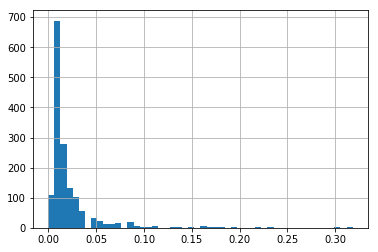

In [8]:
df.avg_week.hist(bins=50)

In [9]:
md("""### Median of average crash per segment is %1.4f , while the average = %1.4f . 
### There are few outliers with high average crashes (4th quantile = %1.4f). The segment %s has the highest average crashes with average per week crash = %1.4f
"""% ( 
    df.avg_week.median() , df.avg_week.mean() , df.avg_week.quantile(0.75),
    df[df.avg_week==df.avg_week.max()].segment_id.values[0] , df.avg_week.max()
    )
  )

### Median of average crash per segment is 0.0076 , while the average = 0.0199 . 
### There are few outliers with high average crashes (4th quantile = 0.0227). The segment 001849 has the highest average crashes with average per week crash = 0.3182


# In this analysis, we consider segments with top quantile as "High risk" segment

In [10]:
high_risk = pd.Series((df.avg_week > df.avg_week.quantile(0.75)))
high_risk.value_counts()

False    1208
True      313
Name: avg_week, dtype: int64

In [11]:
df_with_crash = df[high_risk]
df_without_crash = df[~high_risk]

In [12]:
df_with_crash.shape , df_without_crash.shape

((313, 53), (1208, 53))

## We are selecting a subset of columns which we will use in further analysis
## Dropping variables like segement_id, target, pre_week,etc  

In [13]:
df_with_crash.columns

Index(['segment_id', 'target', 'pre_week', 'pre_month', 'pre_quarter',
       'avg_week', 'width', 'parking_tickets', 'lanes', 'hwy_type',
       'osm_speed', 'oneway', 'signal', 'seeclickfix', 'lanes0', 'lanes1',
       'lanes2', 'lanes3', 'lanes4', 'lanes5', 'lanes6', 'hwy_type0',
       'hwy_type1', 'hwy_type2', 'hwy_type3', 'hwy_type4', 'hwy_type5',
       'hwy_type6', 'hwy_type7', 'hwy_type8', 'hwy_type9', 'hwy_type10',
       'hwy_type11', 'hwy_type12', 'hwy_type13', 'hwy_type14', 'hwy_type15',
       'hwy_type16', 'osm_speed0', 'osm_speed20', 'osm_speed25', 'osm_speed40',
       'oneway0', 'oneway1', 'signal0', 'signal1', 'signal2', 'signal3',
       'signal4', 'signal5', 'log_width', 'log_parking_tickets',
       'intersection'],
      dtype='object')

In [14]:
df_minimal_columns = df[
                        df_with_crash.columns[
                            ~df_with_crash.columns.isin(['segment_id','target','log_width','log_parking_tickets','pre_week', 'pre_month', 'pre_quarter','avg_week'])
                        ]
                    ].fillna(0)

In [15]:
df_minimal_columns.columns

Index(['width', 'parking_tickets', 'lanes', 'hwy_type', 'osm_speed', 'oneway',
       'signal', 'seeclickfix', 'lanes0', 'lanes1', 'lanes2', 'lanes3',
       'lanes4', 'lanes5', 'lanes6', 'hwy_type0', 'hwy_type1', 'hwy_type2',
       'hwy_type3', 'hwy_type4', 'hwy_type5', 'hwy_type6', 'hwy_type7',
       'hwy_type8', 'hwy_type9', 'hwy_type10', 'hwy_type11', 'hwy_type12',
       'hwy_type13', 'hwy_type14', 'hwy_type15', 'hwy_type16', 'osm_speed0',
       'osm_speed20', 'osm_speed25', 'osm_speed40', 'oneway0', 'oneway1',
       'signal0', 'signal1', 'signal2', 'signal3', 'signal4', 'signal5',
       'intersection'],
      dtype='object')

In [17]:
df_minimal_columns.head()

,width,parking_tickets,lanes,hwy_type,osm_speed,oneway,signal,seeclickfix,lanes0,lanes1,...,osm_speed40,oneway0,oneway1,signal0,signal1,signal2,signal3,signal4,signal5,intersection
0,0,1,2,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,21,3762,2,1,0,0,0,15,0,0,...,0,1,0,1,0,0,0,0,0,0
2,21,272,2,5,0,0,0,4,0,0,...,0,1,0,1,0,0,0,0,0,0
3,15,23,2,0,0,1,0,10,0,0,...,0,0,1,1,0,0,0,0,0,0
4,15,187,2,5,25,0,0,8,0,0,...,0,1,0,1,0,0,0,0,0,0


## To find the variables which make a contribution to a segment being a high risk or not, we use the following approach
## We apply t-test on the continous variables to find if mean of those variables are different in high risk and not high risk segments. We further use p-value to test statistical significance.
## For the boolean variables, we use proportion difference between average crash of high risk and non high-risk segments.


In [21]:
col_with_significance = []
col_with_no_significance = []

for col in df_minimal_columns.columns:
    if (str(df[col].dtype) in ['int64','float64']):
        # and str(col) not in ['SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp','F_F_Class']) :
        val = stats.ttest_ind(df_with_crash[col],df_without_crash[col],equal_var=False)
        col_with_significance.append({ 'pvalue': val.pvalue, 'col': col }) if val.pvalue < 0.05 else   col_with_no_significance.append({ 'pvalue': val.pvalue, 'col': col })
    elif str(df[col].dtype) in ['uint8']:
        val = df_with_crash[col].mean() - df_without_crash[col].mean()
        col_with_significance.append({ 'proportion_difference': val, 'col': col }) if np.abs(val) > 0.05 else   col_with_no_significance.append({ 'proportion_difference': val, 'col': col })


# Features of segment with different distribution in high risk and non high risk segments

In [22]:
pd.DataFrame(col_with_significance)

,col,proportion_difference,pvalue
0,width,NaN,4.908693e-16
1,parking_tickets,NaN,3.454488e-02
2,lanes,NaN,1.034583e-12
3,hwy_type,NaN,3.938284e-11
4,oneway,NaN,1.937938e-02
5,signal,NaN,4.577088e-16
6,seeclickfix,NaN,5.817827e-07
7,lanes2,-0.166253,NaN
8,lanes3,0.097180,NaN
9,lanes4,0.112443,NaN


# Features of segment with ***similar***  distribution in high risk and non high risk segments ( We will not use these features in further analysis)

In [23]:
pd.DataFrame(col_with_no_significance)

,col,proportion_difference,pvalue
0,osm_speed,NaN,0.260068
1,lanes0,-0.004488,NaN
2,lanes1,-0.045749,NaN
3,lanes5,0.007696,NaN
4,lanes6,-0.000828,NaN
5,hwy_type3,0.006273,NaN
6,hwy_type4,0.002367,NaN
7,hwy_type6,0.005446,NaN
8,hwy_type7,0.024266,NaN
9,hwy_type8,-0.003311,NaN


# Apply TSNE on the data to visualize how data is distributed

In [24]:
df_input = df_minimal_columns.fillna(0)
X_tsne = TSNE(n_components=2,random_state=12345).fit_transform(df_input)
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]

# We are plotting three TSNE graphs
## with high risk segments only
## with not high risk segments only
## high risk and not high risk segments together (red color for high risk)

## The reason of having three separate graphs is because sometimes points of different overlap each other. So, to avoid such visualization issue, we plot three different plots as mentioned above

## TSNE tries its best to transform how data points are distributed in an N-dimensional space into 2D while preserving the distances between each pair of vector (data point, here segments)

# High Risk Segments are well distributed with some visible clusters

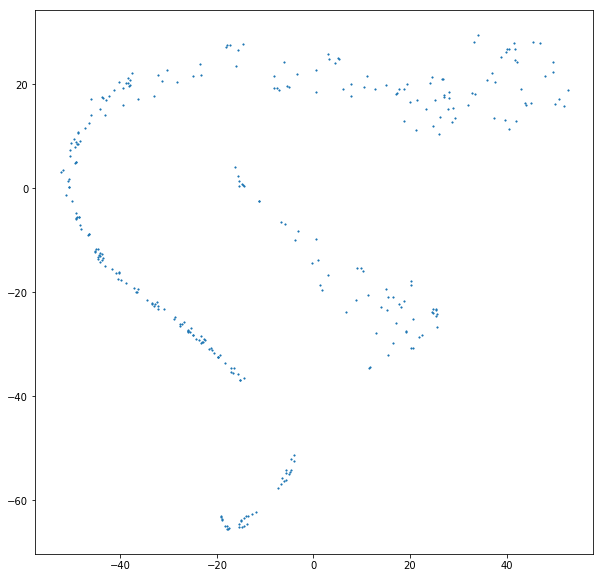

In [25]:
plt.figure(figsize=[10,10])
plt.scatter(
        vis_x[high_risk] ,
        vis_y[high_risk],
        s=1,
        marker="X",
        )

# Non High Risk Segments have similar patterns as high risk segments, though density of non high risk segment is more uniform than high risk segments

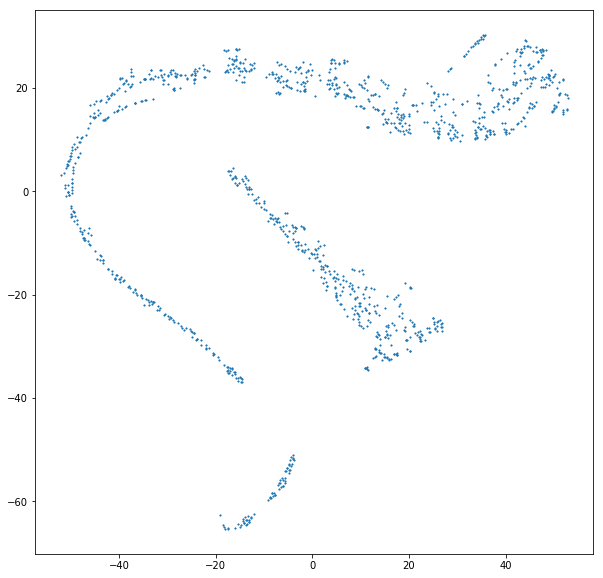

In [26]:
plt.figure(figsize=[10,10])
plt.scatter(
        vis_x[~high_risk] ,
        vis_y[~high_risk],
        s=1,
        marker="X",
        )

# High risk (red) and Non high risk segments are plotted together

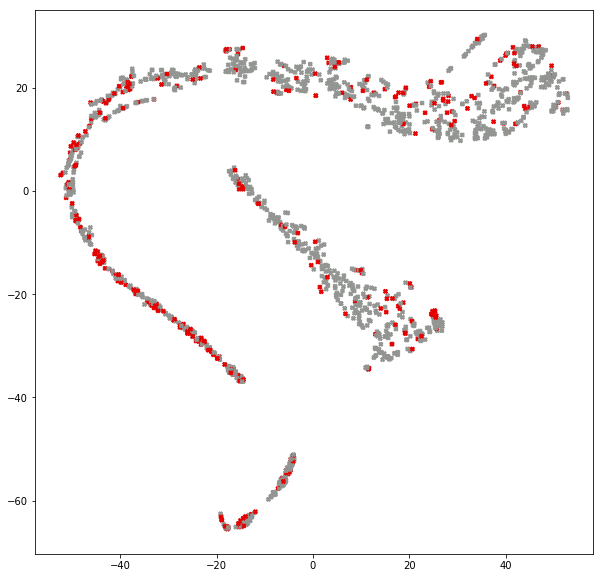

In [27]:
plt.figure(figsize=[10,10])
color_mapping = {0: sns.xkcd_rgb['grey'], 1: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], high_risk))
plt.scatter(
        vis_x ,
        vis_y,
        s=16,
        marker="X",
        c = colors
        )

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [28]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

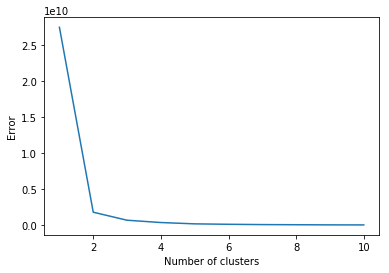

In [29]:
# X_scale = preprocessing.normalize(df_minimal_columns, norm='l2')
evaluate_clusters(df_minimal_columns.fillna(0),10)
plt.show()

In [47]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 2

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred



In [48]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

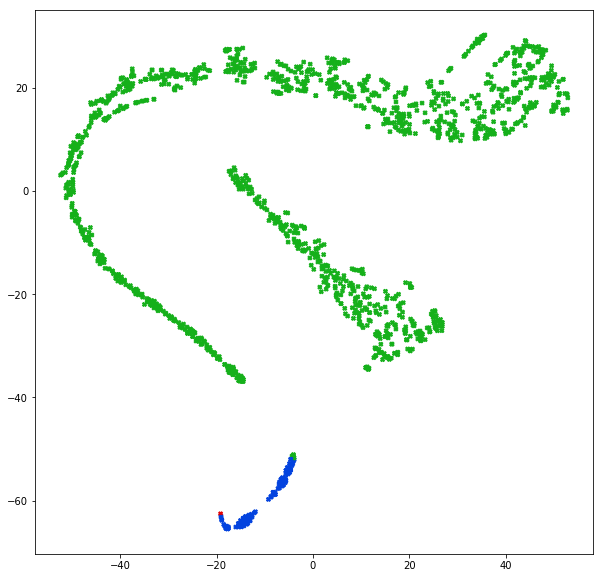

In [42]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        vis_x ,
        vis_y,
        s=16,
        marker="X",
        c = colors
        )

In [43]:
df['cluster_label'] =  cluster_labels
df.head()

,segment_id,target,pre_week,pre_month,pre_quarter,avg_week,width,parking_tickets,lanes,hwy_type,...,signal0,signal1,signal2,signal3,signal4,signal5,log_width,log_parking_tickets,intersection,cluster_label
0,0010,0,0,1,1,0.007576,0,1,2,1,...,1,0,0,0,0,0,0.000000,0.693147,0,0
1,00100,0,0,0,0,0.030303,21,3762,2,1,...,1,0,0,0,0,0,3.091042,8.232972,0,2
2,001001,0,0,0,1,0.007576,21,272,2,5,...,1,0,0,0,0,0,3.091042,5.609472,0,0
3,001009,0,0,0,0,0.007576,15,23,2,0,...,1,0,0,0,0,0,2.772589,3.178054,0,0
4,001014,0,0,0,0,0.007576,15,187,2,5,...,1,0,0,0,0,0,2.772589,5.236442,0,0


In [44]:
#checking incidents for each cluster
print("Average Weekly Crash in")

for cluster in set(cluster_labels):
    print("cluster %s : %1.4f"%(str(cluster), df[df['cluster_label'] ==cluster]['avg_week'].mean()))

print("\nMean and median crashes: %1.4f , %1.4f"% (df['avg_week'].mean()  ,df['avg_week'].median() ))

Average Weekly Crash in
cluster 0 : 0.0195
cluster 1 : 0.0227
cluster 2 : 0.0271

Mean and median crashes: 0.0199 , 0.0076


# Next step is to find key characteristics of these clusters
## For that we choose top features which are different in the given cluster when compared with the rest of the clusters
## We select those specific features to explain the characteristics of the clusters
## We could have selected same set of features to explain each cluster but we used this method to focus on the key characteritics of the cluster

### In the given method, we compare each cluster with all points not in the given cluster
### We select the features with lowest p value and print the characteristics of the given cluster

In [45]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.as_matrix()
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.as_matrix(),random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [46]:
for result in get_top_features_from_dataset(df_minimal_columns, cluster_labels,n_clusters):
    #Get top 5 value of pvalues
    top_5_p_values_indeces = np.argsort(result['pvalues'])[0:8]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f"%df[df['cluster_label'] == int(result['cluster_label']) ]['avg_week'].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in top_5_p_values_indeces:
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': df[df['cluster_label'] == int(result['cluster_label']) ][name].mean() ,
            'mean (overall)': df[name].mean(),
            'proportion ratio': df[df['cluster_label'] == int(result['cluster_label']) ][name].mean() / df[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    



Cluster : 0
-------
Mean crashes: 0.01948
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
parking_tickets       220.218093      545.646285          0.403591
      hwy_type0         0.380084        0.361604          1.051105
         lanes3         0.064516        0.072978          0.884045
     hwy_type12         0.002104        0.003945          0.533310
      hwy_type2         0.056101        0.062459          0.898206
          width        15.535063       15.696252          0.989731
      hwy_type1         0.124123        0.132150          0.939262
       hwy_type         2.639551        2.700197          0.977540


Cluster : 1
-------
Mean crashes: 0.02273
Characteristics of cluster 1
feature_name  mean in cluster  mean (overall)  proportion ratio
parking_tickets         160863.0      545.646285        294.811867
         lanes3              1.0        0.072978         13.702703
      hwy_type1              1.0        0.132150        